# Exploration des partis et leur évolution dans le temps 

Dans ce carnet est proposée une exploration des partis de la population Wikidata retenue.

On essayera de prendre connaissance des liens entre les noms des partis, le genre et les générations

In [5]:
### Librairie à installer dans l'environnement conda
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, SPARQLWrapper2, JSON, TURTLE, XML, RDFXML

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [8]:
### https://mwouts.github.io/itables/quick_start.html

from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=False)


ModuleNotFoundError: No module named 'itables'

In [4]:
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder

ModuleNotFoundError: No module named 'mlxtend'

In [ ]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


In [4]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

NameError: name 'sys' is not defined

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [ ]:
## define SPARQL enpoint
endpoint = "https://query.wikidata.org/sparql"

In [ ]:
query = """
SELECT DISTINCT ?item ?itemLabel ?parti ?partiLabel ?birthDate
        WHERE {
            { 
          {?item wdt:P39 wd:Q18510612} #p39 position held et Q18510612 pour conseil national
            UNION
            {?item wdt:P17 wd:Q39} # p17 country et Q39 switzerland, cet UNION permet de restreindre les résultats uniquement à la Suisse
              }
          
?item wdt:P31 wd:Q5;  # Any instance of a human.
     wdt:P569 ?birthDate;
     wdt:P102 ?parti.
          
        BIND(REPLACE(str(?birthDate), "(.*)([0-9]{4})(.*)", "$2") AS ?year)
        FILTER(xsd:integer(?year) > 1900 )
          
          SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
        } 
     ORDER BY ?year
"""

In [ ]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [ ]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

69010


[['http://www.wikidata.org/entity/Q855257',
  'http://www.wikidata.org/entity/Q155647',
  'astrologer'],
 ['http://www.wikidata.org/entity/Q855257',
  'http://www.wikidata.org/entity/Q170790',
  'mathematician'],
 ['http://www.wikidata.org/entity/Q855257',
  'http://www.wikidata.org/entity/Q1622272',
  'university teacher']]

In [ ]:
### Créer un DataFrame à partir du résultat
df_r = pd.DataFrame(r)
df_r.columns = ['personUri', 'person_label', 'partiUri', 'partiLabel']
df_r.head()

,personUri,occupationUri,occupationLabel
0,http://www.wikidata.org/entity/Q855257,http://www.wikidata.org/entity/Q155647,astrologer
1,http://www.wikidata.org/entity/Q855257,http://www.wikidata.org/entity/Q170790,mathematician
2,http://www.wikidata.org/entity/Q855257,http://www.wikidata.org/entity/Q1622272,university teacher
3,http://www.wikidata.org/entity/Q855257,http://www.wikidata.org/entity/Q4964182,philosopher
4,http://www.wikidata.org/entity/Q4121967,http://www.wikidata.org/entity/Q11063,astronomer


In [ ]:
df_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69010 entries, 0 to 69009
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   personUri        69010 non-null  object
 1   occupationUri    69010 non-null  object
 2   occupationLabel  69010 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


## Créer une nouvelle table dans la base de données SQLite

In [ ]:
### Se connecter à la base de données dans laquelle on va insérer
# le résultat de la requête SPARQL
cn = sql.connect('../../data/conseil_national_import.db')
cn

In [ ]:
### Créer une nouvelle table contenant le DataFrame
# Si on tente de la recréer, alor qu'elle existe déjà,
# un message d'erreur est renvoyé
try:
    l = df_r.to_sql(name='wdt_person_parti', con=cn, if_exists='fail')
except Exception as e:
    print('Erreur: ',  e)

In [ ]:
### Vérifier que les données ont été importées correctement
cur = cn.cursor()
l = cur.execute("SELECT * FROM wdt_person_parti limit 3").fetchall()
### On a mis le résultat de la requête SQL 
# dans une liste 'l' qu'on affiche avec une boucle 'for'
# dans le cadre d'une 'list comprehension'
a = [print(e) for e in l]

(0, 'http://www.wikidata.org/entity/Q855257', 'http://www.wikidata.org/entity/Q155647', 'astrologer')
(1, 'http://www.wikidata.org/entity/Q855257', 'http://www.wikidata.org/entity/Q170790', 'mathematician')
(2, 'http://www.wikidata.org/entity/Q855257', 'http://www.wikidata.org/entity/Q1622272', 'university teacher')


## Prendre connaissance des occupations

In [ ]:
cn = sql.connect('../../data/conseil_national_import.db')

In [ ]:
q="""
SELECT partiUri, partiLabel, COUNT(*) as effectif
FROM wdt_person_parti
GROUP BY partiUri , partiLabel
ORDER BY effectif DESC
"""
cur = cn.cursor()
r = cur.execute(q).fetchall()
rdf = pd.DataFrame(r,columns=['uri', 'label', 'freq'])
rdf.head()

,uri,label,freq
0,http://www.wikidata.org/entity/Q169470,physicist,25557
1,http://www.wikidata.org/entity/Q11063,astronomer,8050
2,http://www.wikidata.org/entity/Q1622272,university teacher,7619
3,http://www.wikidata.org/entity/Q170790,mathematician,2971
4,http://www.wikidata.org/entity/Q36180,writer,1181


In [ ]:
rdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   uri     1280 non-null   object
 1   label   1280 non-null   object
 2   freq    1280 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 30.1+ KB


In [ ]:
### Après avoir crée avec SQLite Studio une table 'wdt_parti'
# la remplir avec une ligne par parti


q2 = """
INSERT INTO wdt_parti (wdt_uri,label)
SELECT partiUri, partiLabel
FROM wdt_person_parti
GROUP BY partiUri , partiLabel ;
"""

## Attention : la requête est commentée pour éviter 
# de la réexécuter par mégarde

cur = cn.cursor()
# r = cur.execute(q2)
cn.commit()

In [ ]:
### ATTENTION : ces requêtes vident la table wdt_parti et remettent 
# la séquence des primary keys au début: la première valeur sera donc 1
q3 = """
DELETE FROM wdt_parti  ;
"""

q4="""UPDATE SQLITE_SEQUENCE 
    SET seq = 0
    WHERE name ='wdt_parti';
    """

cur = cn.cursor()
#r = cur.execute(q2)
#r1 = cur.execute(q4)
cn.commit()

In [ ]:
### Le nombre de partis différents: noter qu'il y des répétitions
## et inconsistances dans les données de Wikidata

q="""
SELECT COUNT(*)
FROM wdt_parti
"""
cur = cn.cursor()
r = cur.execute(q).fetchone()
print('Nombre de partis différents:' , r[0])

Nombre de métiers différents: 1280


In [ ]:
## Vérifier que le DataFrame rdf contient le même nombre de modalités
print(len(rdf))

1280


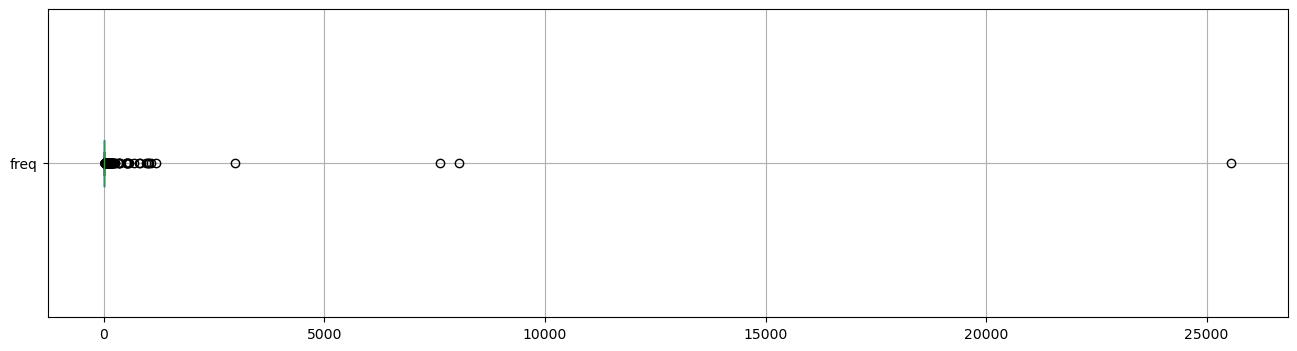

In [ ]:
### Disribution des partis
## On observe une masse de partis avec peu d'effectifs,
# et quelques partis très courants.
# Ils sont représentées en tant que valeurs extrêmes
rdf.boxplot(column=['freq'], vert=False, figsize=(16,4))
plt.show()


In [ ]:
### On transforme en DataFrame le résultat du regroupement par fréquence

q="""
WITH tw1 AS (
SELECT partiUri, trim(partiLabel) partiLabel, COUNT(*) as effectif
FROM wdt_person_parti
GROUP BY partiUri, partiLabel )
SELECT effectif, count(*) as freq, group_concat(partiLabel, '; ')
FROM tw1
GROUP BY effectif;
"""
cur = cn.cursor()
r = cur.execute(q).fetchall()

dfr = pd.DataFrame(r, columns=['effectif','nombre', 'labels'])
dfr.head()

,effectif,nombre,labels
0,1,591,Buddhologist; science teacher; knight; physica...
1,2,168,crime fiction writer; racing automobile driver...
2,3,87,civil rights advocate; computer engineer; muse...
3,4,68,applied mathematician; bibliographer; electron...
4,5,28,humanist; columnist; science administrator; cr...


In [ ]:
## exemple de lecture, ligne 9:  il y a 18 cas de métiers pratiqués par 10 individus >> a recommenter
# et donc il y a presque 600 métiers mentionnés une seule fois !

show(dfr[dfr['effectif'] < 100],  scrollY="300px", scrollCollapse=True, paging=False, 
     showIndex=False, column_filters="header", columnDefs=[{"className": "dt-left", "targets": "_all"}])

Loading... (need help?)


In [ ]:
### Représenter les valeurs les plus fréquentes


show(dfr[dfr['effectif'] > 99],  scrollY="300px", scrollCollapse=True, paging=False, 
     showIndex=False, column_filters="header", layout={"topEnd": None}, 
     columnDefs=[{"className": "dt-left", "targets": "_all"}], style="table-layout:auto;width:50%;float:left")

Loading... (need help?)


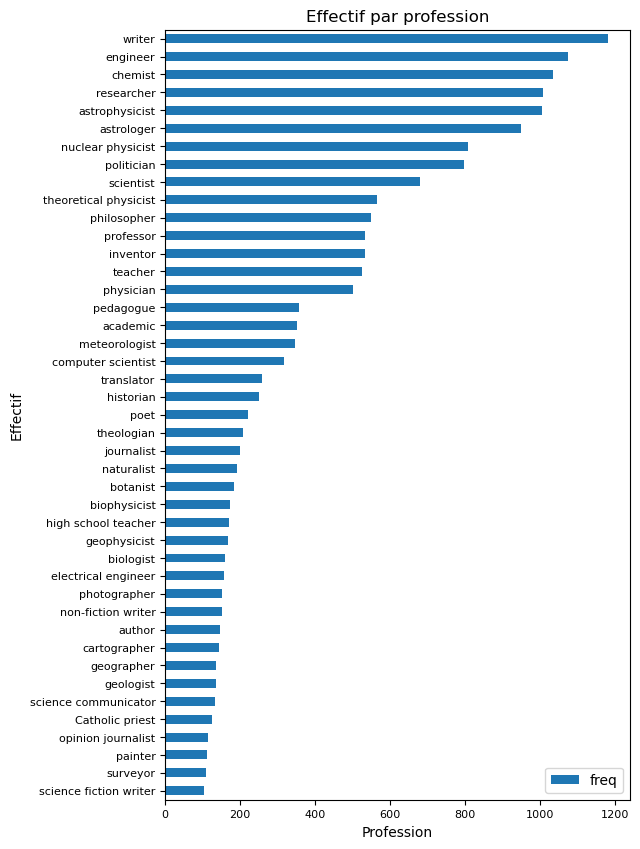

In [ ]:
### Représentation graphique des effectifs par année

ax = rdf[(rdf['freq']>100) & (rdf['freq'] < 2000)].sort_values(by='freq', ascending=True).plot(x='label', y='freq', 
                 kind='barh', fontsize=8, figsize=(6, 10)) # ,rot=5


#max_xticks = 20
#xloc = plt.MaxNLocator(max_xticks)
#ax.xaxis.set_major_locator(xloc)

plt.ylabel('Effectif')
plt.xlabel('parti')
plt.title('Effectif par parti')
plt.show()

In [ ]:
q="""
SELECT pk_wdt_parti, label, wdt_uri
FROM wdt_parti
"""
cur = cn.cursor()
r = cur.execute(q).fetchall()
[e for e in r][:3]

[(1, 'Buddhologist', 'http://www.wikidata.org/entity/Q100851212'),
 (2, 'physics teacher', 'http://www.wikidata.org/entity/Q101445630'),
 (3, 'science teacher', 'http://www.wikidata.org/entity/Q101445634')]

In [ ]:
q="""
SELECT wp.partiUri, wp.partiLabel, min(wp.genderUri) gender, 
			min(wp.birthYear) birthYear, 
			group_concat(distinct trim(partiLabel) order by partiLabel) partiLabels
FROM wdt_person_parti wpo, wdt_personne wp 
WHERE wp.personUri = wpo.personUri 
GROUP BY wp.personUri, wp.personLabel;
"""
cur = cn.cursor()
r = cur.execute(q).fetchall()
[e for e in r][:3]

[('http://www.wikidata.org/entity/Q1000193',
  'Hans Elsässer',
  'http://www.wikidata.org/entity/Q6581097',
  '1929',
  'astronomer'),
 ('http://www.wikidata.org/entity/Q1000934',
  'Charles Christian Lauritsen',
  'http://www.wikidata.org/entity/Q6581097',
  '1892',
  'nuclear physicist,physicist,university teacher'),
 ('http://www.wikidata.org/entity/Q100153910',
  'Frank J. Blatt',
  'http://www.wikidata.org/entity/Q6581097',
  '1924',
  'physicist,university teacher')]

In [ ]:
### On transforme la liste en DataFrame
df_p = pd.DataFrame(r, columns=['person_uri', 'person_label', 
                        'genderUri', 'birthYear', 'partis'])
df_p = df_p.set_index('person_uri',drop=True)
df_p.head()

,person_label,genderUri,birthYear,occupations
person_uri,,,,
http://www.wikidata.org/entity/Q1000193,Hans Elsässer,http://www.wikidata.org/entity/Q6581097,1929,astronomer
http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,http://www.wikidata.org/entity/Q6581097,1892,"nuclear physicist,physicist,university teacher"
http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,http://www.wikidata.org/entity/Q6581097,1924,"physicist,university teacher"
http://www.wikidata.org/entity/Q100155322,Edgar Knobloch,http://www.wikidata.org/entity/Q6581097,1953,physicist
http://www.wikidata.org/entity/Q100157315,Ding Jing,http://www.wikidata.org/entity/Q6581097,1924,"physicist,university teacher"


In [ ]:
print(len(df_p))

33647


### Ajouter le genre

In [ ]:
### On créé d'abord une fonction qui effectue le travail

## l'argument de la fonction 'g_uri' est un nom choisi librement
# il est ensuite appelé dans la fonction comme variable
# et contient la valeur introduite lors de l'utilisation de la fonction 
def code_gender(g_uri):
    if g_uri == 'http://www.wikidata.org/entity/Q6581097':
        # genre masculin
        a = 'M'
    elif g_uri =='http://www.wikidata.org/entity/Q6581072':
        # genre féminin
        a = 'F'
    else:
        # genre autre
        a = 'A'
    return a    

In [ ]:
### On ajoute une nouvelle colonne et y on met pour chaque ligne le résultat de la fonction
df_p['gender'] = df_p.apply(lambda x: code_gender(x['genderUri']), axis=1)
df_p = df_p.drop(columns=['genderUri'])
### On inspecte les cinq premières lignes qui ont la valeur 'A' = autre
df_p[df_p['gender']=='A'][:5]

,person_label,birthYear,occupations,gender
person_uri,,,,
http://www.wikidata.org/entity/Q124414761,JA Grier,1968,"astronomer,planetary scientist,scientist",A
http://www.wikidata.org/entity/Q125054679,Zhao Wenjin,1991,physicist,A
http://www.wikidata.org/entity/Q15990211,Rachael Padman,1954,"astronomer,astrophysicist,physicist",A
http://www.wikidata.org/entity/Q16913156,Ophelia Pastrana,1982,"YouTuber,actor,businessperson,physicist,televi...",A
http://www.wikidata.org/entity/Q23656158,Lucianne M. Walkowicz,1979,astronomer,A


### Ajouter les périodes

In [93]:
df_p['birthYear'] = df_p['birthYear'].astype(int)
df_p = df_p[df_p['birthYear'] < 2001].copy(deep=True)

In [94]:
print(min(df_p['birthYear']),max(df_p['birthYear']))

1355 2000


In [99]:
l_per = [1351, 1501, 1701, 1801, 1901, 2001]

In [100]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_p['periodes'] = pd.cut(df_p['birthYear'], l_per, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['periodes'] = df_p['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.head(3)

,person_label,birthYear,occupations,gender,periodes
person_uri,,,,,
http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929,astronomer,M,1901-2000
http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,1892,"nuclear physicist,physicist,university teacher",M,1801-1900
http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,1924,"physicist,university teacher",M,1901-2000


## Filtre sur les partis

In [108]:
def filter_parti( x, list ):
    for e in list:
        if e in x.partis:
            a = True
            break
        else:
            a = False
    return a           

In [109]:
### Les partis les plus fréquentes
ll = [e.split('; ') for e in dfr['labels'][dfr['effectif'] > 99].to_list()]
lpf= []
for e in ll:
    lpf = lpf + e

lpf = list(set(lpf))
print(len(lpf))

47


In [110]:
### Les partis souhaitées >> modifier les valeurs
lpf=['non-fiction writer','photographer']
lpf=['astrologer']

In [111]:
filtered_df_p = df_p[df_p.apply(lambda x: filter_parti(x, lpf), axis=1)]
print(len(filtered_df_p))
filtered_df_p.head()

909


,person_label,birthYear,occupations,gender,periodes
person_uri,,,,,
http://www.wikidata.org/entity/Q100234964,Alessandro De Angelis,1559,"astrologer,theologian",M,1501-1700
http://www.wikidata.org/entity/Q100708787,Patric Walker,1931,"astrologer,writer",M,1901-2000
http://www.wikidata.org/entity/Q100715,Alfons Rosenberg,1902,"astrologer,writer",M,1901-2000
http://www.wikidata.org/entity/Q10272446,Emma Costet de Mascheville,1903,astrologer,F,1901-2000
http://www.wikidata.org/entity/Q1029283,David Pingree,1933,"astrologer,historian of mathematics,mathematic...",M,1901-2000


In [101]:
### Ajouter des filtres supplémentaires
l = filtered_df_p['parti'].to_list()
len(l)

920

In [102]:
### toutes les nationalités (même multiples)
lb = [sorted([i.strip().replace(' ', '_') for i in e.split(',')]) for e in l]
lb[:3]

[['astrologer', 'theologian'],
 ['astrologer', 'writer'],
 ['astrologer', 'writer']]

In [104]:
te = TransactionEncoder()
te_ary = te.fit_transform(lb)
data_df=pd.DataFrame(te_ary, columns=te.columns_)
data_df.head()

,Anglican_priest,Blavatskian_theosophy,Buddhologist,Catholic_bishop,Catholic_priest,Catholic_theologian,Christian_minister,Christian_mystic,Esperantist,Latin_Catholic_priest,...,typographer,university_teacher,vedette,violinist,visual_artist,voice_actor,witchcraft,writer,yogi,zoologist
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


In [105]:
frequent_itemsets = apriori(data_df, min_support= 0.05, use_colnames=True)
frequent_itemsets['eff'] = frequent_itemsets['itemsets'].apply(lambda x : len(x))
frequent_itemsets['l_itemsets'] = frequent_itemsets['itemsets'].apply(lambda x : sorted(list(x)))
show(frequent_itemsets.sort_values(by='support', ascending=False),
    scrollY="200px", scrollCollapse=True, paging=False) 

In [113]:
###  Créer une fonction d'exploration

def explore_partis(lpf, gender='', periodes=[] ):
    filtered_df_p = df_p[df_p.apply(lambda x: filter_occupation(x, lpf), axis=1)]
    print(len(filtered_df_p))

    if len(gender) > 0:
        l = filtered_df_p[filtered_df_p['gender']== gender]['partis'].to_list()
    else:
        l = filtered_df_p['partis'].to_list()
    
    
    
    lb = [sorted([i.strip().replace(' ', '_') for i in e.split(',')]) for e in l]
    te = TransactionEncoder()
    te_ary = te.fit_transform(lb)
    data_df=pd.DataFrame(te_ary, columns=te.columns_)
    frequent_itemsets = apriori(data_df, min_support= 0.05, use_colnames=True)
    frequent_itemsets['eff'] = frequent_itemsets['itemsets'].apply(lambda x : len(x))
    frequent_itemsets['l_itemsets'] = frequent_itemsets['itemsets'].apply(lambda x : sorted(list(x)))
    show(frequent_itemsets.sort_values(by='support', ascending=False),
        scrollY="200px", scrollCollapse=True, paging=False) 
    
    return None


In [121]:
lpf=['software_engineer']  # writer, philosopher >> renommer
explore_occupations(lpf,gender='F')

0


In [122]:
lpf=['software_engineer'] # renommer
explore_occupations(lpf,gender='M')

0
